# Sparkify Project Workspace

This is a [Udacity nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) project (Data Science Capstone).
This project uses users' event data from Sparkify, which is an imaninary digital music service similar to Spotify or Pandora, to build a model to predict users' churn.

The original dataset is 12GB but a small subset of the dataset (128MB) will be used in this notebook.

In [28]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [29]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [30]:
# Read in full sparkify dataset
event_data = "../input/mini_sparkify_event_data.json"
df = spark.read.json(event_data)

# Load and Clean Dataset

In this notebook, the file name, `mini_sparkify_event_data.json`, will be loaded and cleaned such as handling of invalid or missing values.

The first five rows of the dataset.

In [31]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

Schema information

* artist: Artist name (ex. Daft Punk)
* auth: User authentication status (ex. Logged)
* firstName: User first name (ex. Colin)
* gender: Gender (ex. F or M)
* itemInSession: Item count in a session (ex. 52)
* lastName: User last name (ex. Freeman)
* length: Length of song (ex. 223.60771)
* level: User plan (ex. paid)
* location: User's location (ex. Bakersfield)
* method: HTTP method (ex. PUT)
* page: Page name (ex. NextSong)
* registration: Registration timestamp (unix timestamp) (ex. 1538173362000)
* sessionId: Session ID (ex. 29)
* song: Song (ex. Harder Better Faster Stronger)
* status: HTTP status (ex. 200)
* ts: Event timestamp(unix timestamp) (ex. 1538352676000)
* userAgent: User's browswer agent (ex. Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0)
* userId: User ID (ex. 30)

In [32]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Statistics

Statistics of the whole dataset

In [33]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

Statistics of the `artist` column

In [34]:
df.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



Statistics of the `sessionId` column

In [35]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630834|
|    min|                1|
|    max|             2474|
+-------+-----------------+



Statistics of the `userId` column

In [36]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910519|
|    min|                  |
|    max|                99|
+-------+------------------+



Total rows: 286,500

In [37]:
df.count()

286500

All the `page` events in the dataset:

- About
- Add Friend
- Add to Playlist
- Cancel
- Cancellation Confirmation: **This even wil be used as a flag of churn**
- Downgrade
- Error
- Help 
- Home
- Login 
- Logout
- NextSong 
- Register 
- Roll Advert
- Save Settings 
- Settings
- Submit Downgrade
- Submit Registration
- Submit Upgrade
- Thumbs Down
- Thumbs Up
- Upgrade

`page` kind

In [38]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



## missing values

In [39]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

Check how many missing values in each column

In [40]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


`userId` and `sessionId`

If the below Ids are null or empty, delete those rows:

* userId
* sessionId

In [41]:
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_without_missing_id = df_without_missing_id.filter(df["userId"] != "") # `userId` should not be empty string

In [42]:
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_without_missing_id.count())) # no missing values

if df.count() == df_without_missing_id.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

df:                    286500
df_without_missing_id: 278154
8346 rows have been removed.


# Exploratory Data Analysis

Detect number columns and category columns.

* num_cols: Number columns (Long or Double)
* cat_cols: Category columns (String)

In [43]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [44]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [45]:
cat_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

## Number columns

In [46]:
df_without_missing_id.describe(num_cols).show()

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|            228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.11718197783722|1.535358834085557E12|1042.5616241362698|209.10321620397335|1.540958915431857...|
| stddev|129.85172939949013| 99.23517921058324| 3.291321616328068E9| 726.5010362219821|30.151388851327823|1.5068287123347573E9|
|    min|                 0|           0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|        3024.66567|       1543247354000|              2474|               40

There are three HTTP status codes:

* 307: Temporary Redirect
* 404: Not Found
* 200: OK

In [47]:
df_without_missing_id.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



### Category columns

auth

In [48]:
df_without_missing_id.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



gender

In [49]:
df_without_missing_id.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



level

In [50]:
df_without_missing_id.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



location (only showing top 10)

In [51]:
df_without_missing_id.select("location").dropDuplicates().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
+--------------------+
only showing top 10 rows



method

In [52]:
df_without_missing_id.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



page

In [53]:
df_without_missing_id.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



userAgent (only showing top 10)

In [54]:
df_without_missing_id.select("userAgent").dropDuplicates().show(10)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 10 rows



### Define Churn

Churn will be defined as when `Cancellation Confirmation` events happen, and users with the events are churned users in this analysis.

churn: `Cancellation Confirmation`

In [55]:
df_without_missing_id.filter("page = 'Cancellation Confirmation'").show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [56]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = df_without_missing_id.withColumn("churned", flag_churned_event("page"))

churned rate (from total event logs)

In [57]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [58]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|    30|     M| paid|       NextSong|   200|1538352117000|      0|
|     9|     M| free|       NextSong|   200|1538352180000|      0|
|    30|     M| paid|       NextSong|   200|1538352394000|      0|
|     9|     M| free|       NextSong|   200|1538352416000|      0|
|    30|     M| paid|       NextSong|   200|1538352676000|      0|
|     9|     M| free|       NextSong|   200|1538352678000|      0|
|     9|     M| free|       NextSong|   200|1538352886000|      0|
|    30|     M| paid|       NextSong|   200|1538352899000|      0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|      0|
|    30|     M| paid|       NextSong|   200|1538353084000|      0|
|     9|     M| free|       NextSong|   200|1538353146000|      0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    

In [59]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [60]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+-----------+------+-------------+-------+-----+-----+
|userId|gender|level|       page|status|           ts|churned|phase|churn|
+------+------+-----+-----------+------+-------------+-------+-----+-----+
|100010|     F| free|   NextSong|   200|1539003534000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003736000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003932000|      0|    0|    0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004195000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004511000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004694000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004918000|      0|    0|    0|
|100010|     F| free|Roll Advert|   200|1539004961000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539005157000|      0|    0|    0|
|100010|     F| free|   N

In [61]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|userId|gender|level|                page|status|           ts|churned|phase|churn|
+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|   125|     M| free|            NextSong|   200|1539317144000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317481000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317711000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317914000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318124000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318515000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318728000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318906000|      0|    0|    1|
|   125|     M| free|         Roll Advert|   200|1539318917000|      0|    0

52 userIds were churned

In [62]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


### Explore Data

In this section, data exploration will be done comparing churned users with not churned users, inspecting if there are any big differences between the two groups.

The below columns will be examined:

* artist
  * [x] the number of artist
* [x] gender: 0 or 1
* length
  * [x] the total length
* [x] level: 0 or 1
* page
  * [x] the number of `Thumbs Up`
  * [x] the number of `Thumbs Down`
* song
  * [x] the number of song

Define a common function to convert churn value (0 or 1) to `Not Churn` or `Churn`

Both matplotlib and seaborn plot libraries require pandas dataframe, not pyspark dataframe, so I need to convert the pyspark dataframe to pandas one. I do this conversion every time for a small subset of the dataset because if I do this conversion for all the dataset, it takes time and causes an error.

In [63]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [64]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

gender

In [65]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,100010,F,Not Churn
1,100010,F,Not Churn
2,100010,F,Not Churn
3,100010,F,Not Churn
4,100010,F,Not Churn


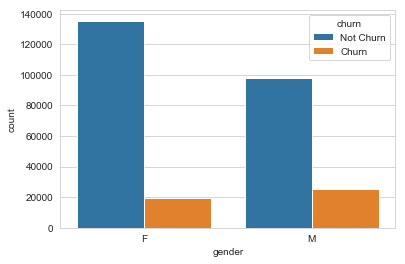

In [66]:
sns.countplot(x="gender", hue="churn", data=pd_gender);

level

In [67]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()

,userId,level,churn
0,100010,free,Not Churn
1,100010,free,Not Churn
2,100010,free,Not Churn
3,100010,free,Not Churn
4,100010,free,Not Churn


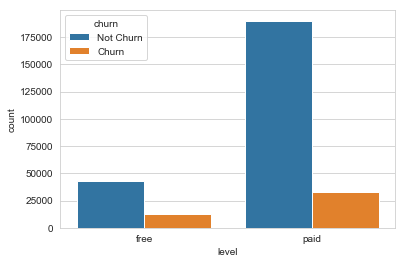

In [68]:
sns.countplot(x="level", hue="churn", data=pd_level);

artist

In [69]:
pd_artist = df_churn_user.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_artist.head()

,userId,churn,artist_count
0,100010,Not Churn,275
1,200002,Not Churn,387
2,125,Churn,8
3,124,Not Churn,4079
4,51,Churn,2111


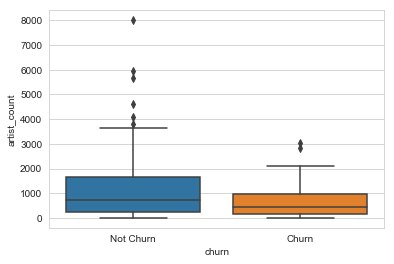

In [70]:
sns.boxplot(x="churn", y="artist_count", data=pd_artist);

song

In [71]:
pd_song = df_churn_user.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", func_churn_label("churn")).toPandas()
pd_song.head()

,userId,churn,song_count
0,100010,Not Churn,275
1,200002,Not Churn,387
2,125,Churn,8
3,124,Not Churn,4079
4,51,Churn,2111


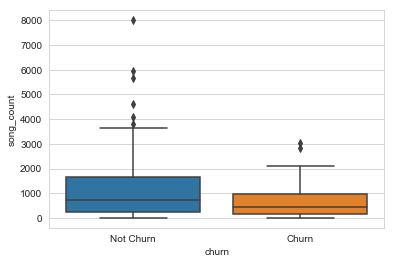

In [72]:
sns.boxplot(x="churn", y="song_count", data=pd_song);

length

In [73]:
pd_length = df_churn_user.join(df_churn.groupby("userId") \
                                       .agg({"length": "sum"}) \
                                       .withColumnRenamed("sum(length)", "total_length"), ["userId"]) \
                          .withColumn("churn", func_churn_label("churn")).toPandas()
pd_length.head()

,userId,churn,total_length
0,100010,Not Churn,6.694090e+04
1,200002,Not Churn,9.400888e+04
2,125,Churn,2.089113e+03
3,124,Not Churn,1.012312e+06
4,51,Churn,5.232758e+05


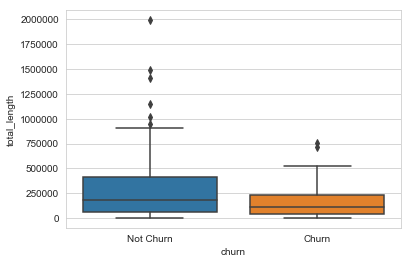

In [74]:
sns.boxplot(x="churn", y="total_length", data=pd_length);

page: total visits

In [75]:
pd_visit = df_churn_user.join(df_churn.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_visit.head()

,userId,churn,visit_count
0,100010,Not Churn,381
1,200002,Not Churn,474
2,125,Churn,11
3,124,Not Churn,4825
4,51,Churn,2464


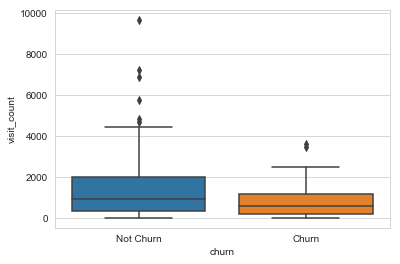

In [76]:
sns.boxplot(x="churn", y="visit_count", data=pd_visit);

page: Thumbs Up / Thumbs Down

up

In [77]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_up.head()

,userId,churn,up_count
0,100010,Not Churn,17
1,200002,Not Churn,21
2,124,Not Churn,171
3,51,Churn,100
4,7,Not Churn,7


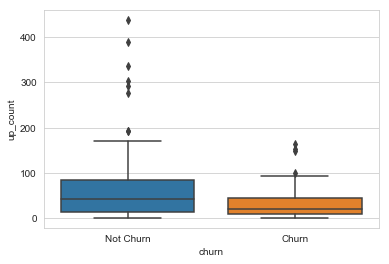

In [78]:
sns.boxplot(x="churn", y="up_count", data=pd_up);

down

In [79]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_down.head()

,userId,churn,down_count
0,100010,Not Churn,5
1,200002,Not Churn,6
2,124,Not Churn,41
3,51,Churn,21
4,7,Not Churn,1


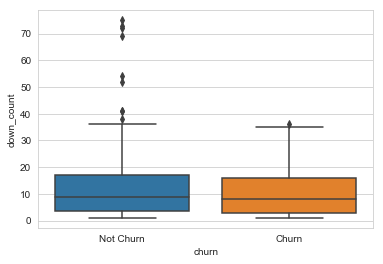

In [80]:
sns.boxplot(x="churn", y="down_count", data=pd_down);

# Feature Engineering

### Feature Engineering Ideas

* artist
  * [x] the number of artist
* [x] gender: 0 or 1
* length
  * [x] the total length
* [x] level: 0 or 1
* page
  * [x] the number of `Thumbs Up`
  * [x] the number of `Thumbs Down`
* song
  * [x] the number of song

In [81]:
df_churn.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|      0|    0|    0|
+--------------------+---------+----

Original dataframe to be merged later

In [95]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [96]:
df_original.show(10)

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
|    15|     0|
|    54|     1|
|   155|     0|
|100014|     1|
+------+------+
only showing top 10 rows



artist count per userId

In [97]:
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



gender

In [98]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
df_churn_with_gender.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     1|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|      0|    0|    0|
+--------------------+---------+----

In [99]:
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   125|     0|
|    51|     0|
|   124|     1|
+------+------+
only showing top 5 rows



length

In [100]:
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000001|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



Page

* Thumbs Up
* Thumbs Down

In [101]:
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|100010|      17|
|200002|      21|
|    51|     100|
|   124|     171|
|     7|       7|
+------+--------+
only showing top 5 rows



In [102]:
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|100010|         5|
|200002|         6|
|    51|        21|
|   124|        41|
|     7|         1|
+------+----------+
only showing top 5 rows



level

In [103]:
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
df_churn_with_level.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098|    0|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|      0|    0|    0|
+--------------------+---------+----

In [104]:
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



song count per userId

In [105]:
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



Join all the features

In [106]:
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [107]:
merged_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|100010|     0|         275|     1|       66940.89735|    0|      17|         5|       275|
|200002|     0|         387|     0| 94008.87593999993|    1|      21|         6|       387|
|   124|     0|        4079|     1|1012312.0927899999|    1|     171|        41|      4079|
|    51|     1|        2111|     0| 523275.8428000001|    1|     100|        21|      2111|
|     7|     0|         150|     0|        38034.0871|    0|       7|         1|       150|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



# Modeling


In this modeling section, the below tasks will be executed to build models. Three machine learning models will be examined and I will decide one of them based on the evaluation results for further hypyer parameter tuning.

* scaling
* train/test split
* build models
  * Logistic Regression
  * Random Forest classifier
  * GBT classifier
* evaluate the models based on f1 score since churned users in the dataset are fairly small so the distribution of target variables are extremely biased.

Drop `userId` column (which is not necessary for modeling)

In [109]:
merged_df_without_user = merged_df.drop("userId")
feature_columns = [col for col in merged_df_without_user.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

Train/Test split

In [110]:
train, test = merged_df_without_user.randomSplit([0.7, 0.3], seed=0)

Build model

In [111]:
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

First, I will try Logistic Regression as a baseline model. Logistic Regression model is much simpler model than other two models. The time needed for training is relatiely shorter than others so it would be a good idea to use this model as a baseline.

In [112]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
param = ParamGridBuilder().build()
model = build_model(lr, param)

In [113]:
%%time
fit_model = model.fit(train)

CPU times: user 5.64 s, sys: 1.84 s, total: 7.49 s
Wall time: 2min 55s


In [114]:
pred = fit_model.transform(test)

All the predicted values are 0 (Not churned)

In [115]:
pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0)]

Even if the predictions are all 0, f1 score is around 0.73 as a result of the imbalanced dataset.

I've decided to use this score as a baseline result and I will try to create a better model.

In [116]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.7324641460234681


### Try different models

Random Forest

In [117]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [118]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 1.62 s, sys: 472 ms, total: 2.09 s
Wall time: 1min 45s


In [119]:
rf_pred = rf_fit_model.transform(test)

In [120]:
rf_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [124]:
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

f1: 0.7757085020242915


GBT

In [125]:
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="target")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [127]:
%%time
gbt_fit_model = gbt_model.fit(train)

CPU times: user 15.2 s, sys: 4.98 s, total: 20.2 s
Wall time: 7min 42s


In [128]:
gbt_pred = gbt_fit_model.transform(test)

In [129]:
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [130]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(gbt_f1_score))

f1: 0.7215309200603317


With default parameters (without hyperparameter tuning), Random Forest gives me a better result than that of GBT classifier.
Let's dig into more on Random Forest.

### Feature Importances

Random Forest

In [131]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,thumb_down,0.277462
1,thumb_up,0.233039
2,artist_count,0.199786
3,song_count,0.101895
4,length,0.098453
5,gender,0.056769
6,level,0.032597


According to the feature importances provided by the Random Forest model, `Thumbs Up` and `Thumbs Down` seem to be important while the level of the users do not really matter.

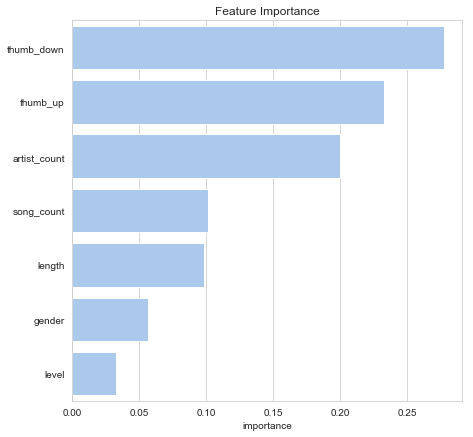

In [132]:
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

### Hyperparameter Tuning